In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
import os
from PIL import Image

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import glob
video_filenames = sorted(glob.glob("./688_full_video_level_data/688/train/*.tfrecord"))

In [3]:
vid_ids = []
labels = []
#mean_rgb = []
new_rgb = []
i = 0
for vfn in video_filenames[:600]:
    i += 1
    for example in tf.python_io.tf_record_iterator(vfn):
        tf_example = tf.train.Example.FromString(example)
        vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
        labels.append(tf_example.features.feature['labels'].int64_list.value)
        new_rgb.append(np.reshape(tf_example.features.feature['mean_rgb'].float_list.value, (32, 32, 1)))
    if i%100 == 0:
        print(str(i) + " tfrecords processed.")

100 tfrecords processed.
200 tfrecords processed.
300 tfrecords processed.
400 tfrecords processed.
500 tfrecords processed.
600 tfrecords processed.


In [ ]:
new_rgb = []
for img in mean_rgb:
    #for i in range(len(img)):
    #    img[i] = (img[i] - np.min(img))/(np.max(img) - np.min(img))
    new_img = np.reshape(img, (32, 32, 1))
    new_rgb.append(new_img)

In [4]:
new_labels = []
for label_list in labels:
    label_one_hot = np.zeros(4716)
    for label in label_list:
        label_one_hot[label] = 1
    new_labels.append(label_one_hot)

In [ ]:
img_width, img_height, img_depth = new_img.shape

In [5]:
datagen = ImageDataGenerator()

In [18]:
new_rgb = np.array(new_rgb)

In [27]:
new_rgb.shape

(719372, 32, 32, 1)

In [20]:
datagen.fit(new_rgb)

In [9]:
new_labels = np.array(new_labels)

In [21]:
feed_data = datagen.flow(new_rgb, new_labels, batch_size = 200)

In [10]:
video_filenames_val = sorted(glob.glob("./688_full_video_level_data/688/validate/*.tfrecord"))
new_rgb_val = []
vid_ids_val = []
labels_val = []
#mean_rgb_val = []
mean_audio_val = []
for vfn in video_filenames_val[:300]:
    for example in tf.python_io.tf_record_iterator(vfn):
        tf_example = tf.train.Example.FromString(example)
        vid_ids_val.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
        labels_val.append(tf_example.features.feature['labels'].int64_list.value)
        new_rgb_val.append(np.reshape(tf_example.features.feature['mean_rgb'].float_list.value, (32, 32, 1)))
        #mean_rgb_val.append(tf_example.features.feature['mean_rgb'].float_list.value)
        #mean_audio_val.append(tf_example.features.feature['mean_audio'].float_list.value)

In [ ]:
new_rgb_val = []
for img in mean_rgb_val:
    #for i in range(len(img)):
    #    img[i] = (img[i] - np.min(img))/(np.max(img) - np.min(img))
    new_img = np.reshape(img, (32, 32, 1))
    new_rgb_val.append(new_img)
    
new_rgb_val = np.array(new_rgb_val)

In [11]:
new_labels_val = []
for label_list in labels_val:
    label_one_hot = np.zeros(4716)
    for label in label_list:
        label_one_hot[label] = 1
    new_labels_val.append(label_one_hot)
new_labels_val = np.array(new_labels_val)

In [29]:
new_rgb_val = np.array(new_rgb_val)

In [30]:
new_labels_val = np.array(new_labels_val)

In [22]:
#Model
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape = (32, 32, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Dropout to prevent overfitting
model.add(Flatten()) #flatten feature map into 1 dimension
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.2))

#final layer to predict probabilities
model.add(Dense(4716))
model.add(Activation("sigmoid"))
#model.add(Activation("softmax"))

In [23]:
#perform gradient descent
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [31]:
model.fit_generator(feed_data, steps_per_epoch = 3600, epochs = 30, validation_data = (new_rgb_val, new_labels_val))
#model.fit(new_rgb, new_labels, epochs = 5, batch_size = 1024, validation_data = (new_rgb_val, new_labels_val))

Epoch 1/20
3600/3600 [==============================] - 1004s 279ms/step - loss: 20.2250 - acc: 0.1412 - val_loss: 18.3001 - val_acc: 0.2036
Epoch 2/20
3600/3600 [==============================] - 938s 261ms/step - loss: 17.1436 - acc: 0.2127 - val_loss: 15.5385 - val_acc: 0.3488
Epoch 3/20
3600/3600 [==============================] - 894s 248ms/step - loss: 15.6592 - acc: 0.3364 - val_loss: 14.7321 - val_acc: 0.3802
Epoch 4/20
3600/3600 [==============================] - 916s 254ms/step - loss: 15.1282 - acc: 0.3539 - val_loss: 14.3478 - val_acc: 0.3786
Epoch 5/20
3600/3600 [==============================] - 905s 251ms/step - loss: 14.8331 - acc: 0.3638 - val_loss: 14.1549 - val_acc: 0.3881
Epoch 6/20
3600/3600 [==============================] - 908s 252ms/step - loss: 14.6353 - acc: 0.3694 - val_loss: 14.0361 - val_acc: 0.4021
Epoch 7/20
3600/3600 [==============================] - 885s 246ms/step - loss: 14.5053 - acc: 0.3721 - val_loss: 13.9321 - val_acc: 0.3966
Epoch 8/20
3600/360

In [ ]:
model.summary()

In [ ]:
score = model.evaluate(new_rgb, new_labels)

In [ ]:
score

In [32]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model_adam_0_7_mil.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('model_adam_0_7_mil.h5')

In [33]:
predicted_labels = model.predict(new_rgb)

In [34]:
import pandas as pd
df = pd.DataFrame.from_csv("vocabulary.csv")

In [35]:
vid_list = df["Name"]

In [43]:
#Training set demo
k = 3269
labels[k]

[52, 26, 12, 58, 2313]

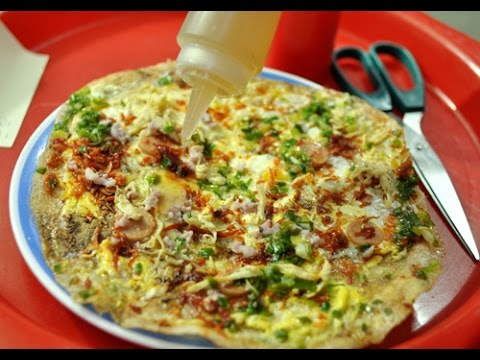

In [44]:
from IPython.display import YouTubeVideo
YouTubeVideo(vid_ids[k])

In [45]:
print("Actual Labels are: ")
for label in labels[k]:
    print(vid_list[label])
actual_len = len(labels[k])
print("\n\nPredicted Labels are: ")

temp_list = []
for i in range(len(predicted_labels[k])):
    temp_list.append((i, predicted_labels[k][i]))
temp_list.sort(key = lambda x: x[1], reverse = True)
for idx, _ in temp_list[:2*actual_len]:
    print(vid_list[idx])
    
labels_common = 0
for idx, _ in temp_list[:2*actual_len]:
    if idx in labels[k]:
        labels_common += 1
print("\n\nNumber of labels that were found common : "+str(labels_common) + " out of " + str(actual_len))

Actual Labels are: 
Dish (food)
Cooking
Food
Cuisine
Bánh


Predicted Labels are: 
Food
Cooking
Recipe
Dish (food)
Cuisine
Cooking show
Kitchen
Animation
Vegetable
Eating


Number of labels that were found common : 4 out of 5


In [38]:
predicted_labels_val = model.predict(new_rgb_val)

In [46]:
new_labels_val.shape

(34339, 4716)

In [47]:
#Validation set demo
k = 21724
labels_val[k]

[1, 4, 70, 1593, 94, 575]

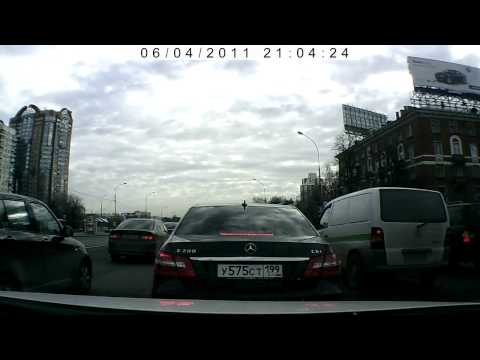

In [48]:
from IPython.display import YouTubeVideo
YouTubeVideo(vid_ids_val[k])

In [49]:
print("Actual Labels are: ")
for label in labels_val[k]:
    print(vid_list[label])
actual_len = len(labels_val[k])
print("\n\nPredicted Labels are: ")

temp_list = []
for i in range(len(predicted_labels_val[k])):
    temp_list.append((i, predicted_labels_val[k][i]))
temp_list.sort(key = lambda x: x[1], reverse = True)
for idx, _ in temp_list[:2*actual_len]:
    print(vid_list[idx])
    
labels_common = 0
for idx, _ in temp_list[:2*actual_len]:
    if idx in labels_val[k]:
        labels_common += 1
print("\n\nNumber of labels that were found common : "+str(labels_common) + " out of " + str(actual_len))

Actual Labels are: 
Vehicle
Car
Driving
Digital video recorder
Dashcam
Traffic


Predicted Labels are: 
Car
Vehicle
Driving
Road
Dashcam
Sports car
Motorsport
Racing
Highway
Race track
Traffic
Supercar


Number of labels that were found common : 5 out of 6


In [41]:
#Calculates the Global Average Precision by Google
print("Global Average Precision for validation Data : ")
N = 20
gap = 0
for i in range(len(labels_val)):
    actual_len = len(labels_val[i])
    temp_list = []
    for j in range(len(predicted_labels_val[i])):
        temp_list.append((j, predicted_labels_val[i][j]))
    temp_list.sort(key = lambda x: x[1], reverse = True)

    num_pos = min(actual_len, N)

    delta_recall = 1.0/num_pos
    
    ap = 0
    labels_common = 0
    N = min(actual_len, N)
    for j in range(N):
        temp_label, _ = temp_list[j]
        if temp_label in labels_val[i]: 
            labels_common += 1
        ap += (float(labels_common)*delta_recall)/(j+1)
    gap += ap
print(gap/len(labels_val))

Global Average Precision for validation Data : 
0.5891213424321552


In [42]:
#Calculates the Global Average Precision by Google
print("Global Average Precision for training Data : ")
N = 20
gap = 0
for i in range(len(labels)):
    actual_len = len(labels[i])
    temp_list = []
    for j in range(len(predicted_labels[i])):
        temp_list.append((j, predicted_labels[i][j]))
    temp_list.sort(key = lambda x: x[1], reverse = True)

    num_pos = min(actual_len, N)

    delta_recall = 1.0/num_pos
    
    ap = 0
    labels_common = 0
    N = min(actual_len, N)
    for j in range(N):
        temp_label, _ = temp_list[j]
        if temp_label in labels[i]: 
            labels_common += 1
        ap += (float(labels_common)*delta_recall)/(j+1)
    gap += ap
print(gap/len(labels))

Global Average Precision for training Data : 
0.5924987350077567


# Rough Work

In [ ]:
from math import ceil

In [ ]:
def em(y_true, y_pred):
    total_count = 0
    for j in range(len(y_true)):
        num_true = 0
        for i in range(4716):#len(y_true[j])
            if y_true[j][i] == 1:
                num_true += 1
        temp_list = []
        for i in range(4716):#len(y_pred[j])
            temp_list.append((i, y_pred[j][i]))
        temp_list.sort(key = lambda x: x[1], reverse = True)
        new_y_pred = temp_list[:2*num_true] #to make sure we cover atleast 50% of common labels
        correct = 0
        for pred,_ in new_y_pred:
            if y_true[j][pred] == 1:
                correct += 1
        if correct >= int(num_true/2):
            total_count += 1
        if j%1000 == 0:
            print(j)
    return ceil((total_count*100)/len(y_true))

In [ ]:
def em2(y_true, y_pred):
    count = 0
    for i in range(439677):
        sum = 0
        for j in range(4716):
            if y_true[i][j] == 1:
                sum += y_pred[i][j]
        if sum > 9e-16:
            count += 1
        if i%10000 == 0:
            print(i)
    return ceil(float(count * 100)/float(len(y_true)))

In [ ]:
print(em2(new_labels, predicted_labels))

In [ ]:
count = 0
total = len(labels_val)
for j in range(total):
    actual_len = len(labels_val[j])

    temp_list = []
    for i in range(len(predicted_labels_val[j])):
        temp_list.append((i, predicted_labels_val[j][i]))
    temp_list.sort(key = lambda x: x[1], reverse = True)

    labels_common = 0
    for idx, _ in temp_list[:2*actual_len]:
        if idx in labels_val[j]:
            labels_common += 1
    #print(labels_common, actual_len/2)
    if labels_common >= actual_len/2:
        count += 1
        #print(count)
print(count*100/total)

In [ ]:
count = 0
#total = len(labels_val)
total = 0
for j in range(len(labels_val)):
    actual_len = len(labels_val[j])

    temp_list = []
    for i in range(len(predicted_labels_val[j])):
        temp_list.append((i, predicted_labels_val[j][i]))
    temp_list.sort(key = lambda x: x[1], reverse = True)

    labels_common = 0
    for idx, _ in temp_list[:actual_len]:
        if idx in labels_val[j]:
            labels_common += 1
    #print(labels_common, actual_len/2)
    #if labels_common >= actual_len/2:
    count += labels_common
    total += actual_len
        #print(count)
print(count*100/total)

In [ ]:
count = 0
total = len(labels)
for j in range(total):
    actual_len = len(labels[j])

    temp_list = []
    for i in range(len(predicted_labels[j])):
        temp_list.append((i, predicted_labels[j][i]))
    temp_list.sort(key = lambda x: x[1], reverse = True)

    labels_common = 0
    for idx, _ in temp_list[:actual_len]:
        if idx in labels[j]:
            labels_common += 1
    #print(labels_common, actual_len/2)
    if labels_common >= actual_len/2:
        count += 1
        #print(count)
print(count*100/total)

In [ ]:
count = 0
#total = len(labels_val)
total = 0
for j in range(len(labels)):
    actual_len = len(labels[j])

    temp_list = []
    for i in range(len(predicted_labels[j])):
        temp_list.append((i, predicted_labels[j][i]))
    temp_list.sort(key = lambda x: x[1], reverse = True)

    labels_common = 0
    for idx, _ in temp_list[:actual_len]:
        if idx in labels[j]:
            labels_common += 1
    #print(labels_common, actual_len/2)
    #if labels_common >= actual_len/2:
    count += labels_common
    total += actual_len
        #print(count)
print(count*100/total)